In [38]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader


from sklearn.model_selection import train_test_split

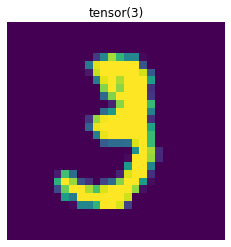

In [39]:
from tensorflow.keras.datasets import mnist


(features_train, targets_train), (features_test, targets_test) = mnist.load_data()

# Convert to float32.

features_train, features_test = np.array(features_train, np.float32), np.array(features_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28).
num_features=784

features_train, features_test = features_train.reshape([-1, num_features]), features_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1].

features_train, features_test = features_train / 255., features_test / 255

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. 
#Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(featuresTrain[10].reshape(28,28))
plt.axis("off")
plt.title(str(targetsTrain[10]))
plt.savefig('graph.png')
plt.show()



In [40]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
        
    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out
# instantiate ANN
input_dim = 28*28
#hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
hidden_dim = 100
output_dim = 10
# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)
# Cross Entropy Loss
criterion =nn.CrossEntropyLoss()
# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [43]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.25512564182281494. Accuracy: 93.29000091552734
Iteration: 1000. Loss: 0.267274409532547. Accuracy: 93.5
Iteration: 1500. Loss: 0.3920717239379883. Accuracy: 93.58999633789062
Iteration: 2000. Loss: 0.1733507364988327. Accuracy: 93.77999877929688
Iteration: 2500. Loss: 0.13997787237167358. Accuracy: 93.87000274658203
Iteration: 3000. Loss: 0.24423940479755402. Accuracy: 94.16000366210938
Iteration: 3500. Loss: 0.19651684165000916. Accuracy: 94.30999755859375
Iteration: 4000. Loss: 0.2141077220439911. Accuracy: 94.5199966430664
Iteration: 4500. Loss: 0.3317601680755615. Accuracy: 94.5199966430664


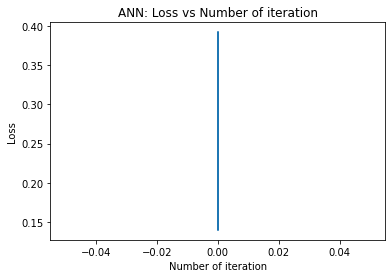

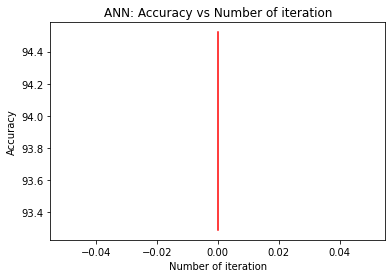

In [44]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [19]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 500  Loss: 0.15019024908542633  Accuracy: 96.87999725341797 %
Iteration: 1000  Loss: 0.06582698225975037  Accuracy: 97.69000244140625 %
Iteration: 1500  Loss: 0.046069178730249405  Accuracy: 98.19000244140625 %
Iteration: 2000  Loss: 0.049927372485399246  Accuracy: 98.31999969482422 %


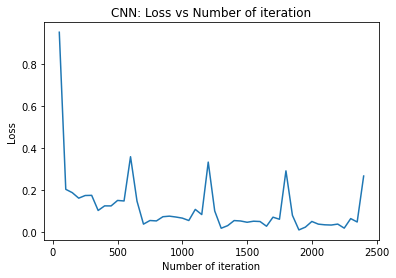

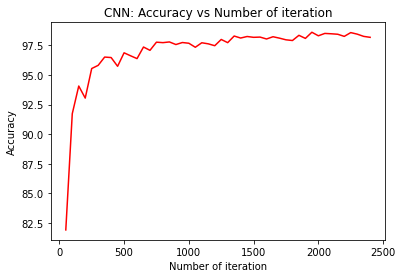

In [21]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

Try CNN on "Fruit" dataset. Also modify number of layers and observe the performance difference: 

https://www.kaggle.com/moltean/fruits


Or (In a case if you don't have that much dataPack available, download 20 images of apple and 20 images of orange from the internet and work on it with RANDOM state=Rollnumber stratergy, 80-20% training-testing division)





